## Welcome to DeepNSD

Keep in mind this is an active work in progress. If you have any issues, please refer to the associated [Github](https://github.com/ColinConwell/DeepNSD) repo(s).

We welcome any and all constructive feedback.

In [1]:
# first things first, we'll clone the Github repo...
# !git clone https://github.com/ColinConwell/DeepDive
# !git clone https://github.com/ColinConwell/DeepNSD
!cp -r DeepDive/deepdive DeepNSD/model_opts #toolbox
!pip install plotnine
%cd ./DeepNSD

/notebooks/DeepNSD


/usr/local/lib/python3.11/dist-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#functions for loading and manipulating the neural data
from neural_data import *
import numpy as np

In [4]:
datapath = 'dataset/nsd_subj01_roi_wise_betas.pkl'
import pickle
with open(datapath, 'rb') as f:
    data = pickle.load(f)

# Check keys
print(data.keys())

dict_keys(['faces', 'bodies', 'places', 'words', 'evc'])


In [5]:
response = np.stack(np.array(data['places']['avg_betas']))
# randomly select 1000 voxels
np.random.seed(42)
voxels = np.random.choice(response.shape[1], 1000, replace=False)
response = response[:, voxels]
response.shape

(10000, 1000)

In [6]:
# load coco imags
cocopath = 'dataset/subj01_unique_stim_dict.pkl'
with open(cocopath, 'rb') as f:
    imagedata = pickle.load(f)
# Check keys
print(imagedata.keys())
print(imagedata['nsd_img'].shape)  # Display first 10 categories

dict_keys(['nsd_id', 'nsd_img', 'coco_super_cat'])
(9000, 425, 425, 3)


In [7]:
cocopath = 'dataset/df_super_cat_dict.pkl'
with open(cocopath, 'rb') as f:
    supercat = pickle.load(f)
# Check keys
print(len(supercat))

9000


In [8]:
import numpy as np
import ast
from collections import Counter
flat_list = np.hstack(supercat)
# Step 3: Count frequencies
counts = Counter(flat_list)
# sort by count
sorted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)
for category, count in sorted_counts:
    print(f"{category}: {count}")

person: 4636
vehicle: 2897
furniture: 2860
kitchen: 2789
sports: 2324
animal: 2071
accessory: 1600
food: 1472
indoor: 1314
electronic: 1255
outdoor: 1026
appliance: 934


In [9]:
class_labels = list(set(flat_list))
print(class_labels)

['accessory', 'vehicle', 'indoor', 'food', 'animal', 'furniture', 'sports', 'electronic', 'outdoor', 'kitchen', 'appliance', 'person']


In [10]:
stim_ids = np.array(data['bodies']['stim_id'])       # shape (10000,)
nsd_ids  = np.array(imagedata['nsd_id'])            # shape (9000,)
# Create a boolean mask of where stim_ids match nsd_ids
mask = np.isin(stim_ids, nsd_ids)
# Get the indices in stim_ids that match nsd_ids
matching_indices = np.where(mask)[0]
assert(nsd_ids == stim_ids[matching_indices]).all()  # Check that the match is correct

In [11]:
voxels = response[matching_indices]
images = imagedata['nsd_img']
labels = supercat  # list of label lists, one per image
class_names = class_labels  # the fixed set of target categories
label_vectors = []
for label_ in labels:
    label_vector = np.zeros(len(class_names))
    for label in label_:
        if label in class_names:
            label_vector[class_names.index(label)] = 1.0
    label_vectors.append(label_vector)
label_vectors = np.stack(label_vectors) 
print(voxels.shape)
print(images.shape)
print(label_vectors.shape)


(9000, 1000)
(9000, 425, 425, 3)
(9000, 12)


In [12]:
np.mean(label_vectors, axis=0)  # Check mean of each class label vector

array([0.14233333, 0.23033333, 0.12922222, 0.13266667, 0.21488889,
       0.23566667, 0.20555556, 0.09322222, 0.10655556, 0.16755556,
       0.07033333, 0.51511111])

In [13]:
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np

images_train, images_test, voxels_train, voxels_test, labels_train, labels_test = train_test_split(
    images, voxels, label_vectors, test_size=0.2, random_state=42, shuffle=True
)

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def to_pil_image(img):
    if isinstance(img, torch.Tensor):
        img = img.detach().cpu().numpy()
    img = np.squeeze(img)  # remove single channel if (1, H, W)
    if img.dtype != np.uint8:
        img = img.astype(np.uint8)
    return Image.fromarray(img)

class MultiLabelDataset(Dataset):
    def __init__(self, images, voxels, labels, transform=None):
        self.images = images
        self.voxels = voxels
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = to_pil_image(self.images[idx])
        if self.transform:
            image = self.transform(image)

        voxel = torch.tensor(self.voxels[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)

        return image, voxel, label

train_dataset = MultiLabelDataset(images_train, voxels_train, labels_train, transform=transform)
test_dataset  = MultiLabelDataset(images_test, voxels_test, labels_test, transform=transform)

train_loader = DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True,
    num_workers=4,       # adjust based on CPU
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=len(test_dataset),
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

In [14]:
# # load test dataset 
# benchmark = NaturalScenesDataset()
# voxels = response[matching_indices]
# allsti = np.hstack(benchmark.stimulus_data.coco_categs)
# lists = [ast.literal_eval(s) for s in allsti]
# flat_list = [item for sublist in lists for item in sublist]
# #extract voxel data for regions: FFA-1, FFA-2, EBA, PPA, FBA-1, FBA-2 
# y = np.array(response[np.array((response.roi_name=='FBA-1') | (response.roi_name=='FBA-2'))].drop(columns=['roi_name','subj_id']))
# df = pd.concat([pd.DataFrame(y.T),benchmark.stimulus_data['image_path'],benchmark.stimulus_data['coco_categs']],axis = 1)
# class MultiLabelDataset_test(Dataset):
#     def __init__(self, data, class_names, transform=None):
#         self.data = data
#         self.transform = transform
#         self.class_names = class_names
#           # list of all classes, e.g., ["person", "dog", ...]

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         row = self.data.iloc[idx]
#         img_path = row["image_path"]
#         image = Image.open(img_path).convert("RGB")

#         if self.transform:
#             image = self.transform(image)
        
#         labels = ast.literal_eval(row["coco_supercategs"]) ## split the labels properly 
#         label_vector = torch.zeros(len(self.class_names), dtype=torch.float32)
#         for label in labels:
#             if label in self.class_names:
#                 label_vector[self.class_names.index(label)] = 1.0

#         voxel = pd.to_numeric(row.drop(['image_path','coco_supercategs']), errors='coerce')
#         voxel = torch.tensor(voxel, dtype=torch.float32)
#         return image, voxel, label_vector

# transform = transforms.Compose([
#     transforms.Resize(256),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                          std=[0.229, 0.224, 0.225])
# ])

# #class_labels = list(set(flat_list))  # common image list COCO labels
# class_labels = ['person','table']
# test_dataset = MultiLabelDataset_test(df, class_labels, transform)
# test_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)


In [15]:
for im, vo, la in train_loader:
    print("Batch of images shape:", im.shape)
    print("Batch of voxels shape:", vo.shape)
    print("Batch of labels shape:", la.shape)
    break  # just to check the first batch

Batch of images shape: torch.Size([128, 3, 224, 224])
Batch of voxels shape: torch.Size([128, 1000])
Batch of labels shape: torch.Size([128, 12])


In [16]:
import torch
import torch.nn as nn
import torchvision.models as models
import numpy as np

# --- Configuration ---
n_epochs = 100
learning_rate = 0.0001
device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_classes = la.shape[1]  # from labels
_, voxels, _ = next(iter(train_loader))
num_voxels = voxels.size(1)  

# --- Modified AlexNet Model ---
# class AlexNetWithVoxels(nn.Module):
#     def __init__(self, voxel_dim, num_classes):
#         super(AlexNetWithVoxels, self).__init__()
#         base_model = models.alexnet(pretrained=True)

#         # Freeze all convolutional layers (i.e., all layers in `features`)
#         for param in base_model.features.parameters():
#             param.requires_grad = False

#         self.features = base_model.features
#         self.avgpool = base_model.avgpool

#         conv_output_dim = 256 * 6 * 6  # output of conv5 after flattening
#         self.classifier = nn.Sequential(
#             nn.Linear(conv_output_dim + voxel_dim, 4096),
#             nn.ReLU(inplace=True),
#             nn.Dropout(),
#             nn.Linear(4096, 4096),
#             nn.ReLU(inplace=True),
#             nn.Dropout(),
#             nn.Linear(4096, num_classes)
#         )

#     def forward(self, images, voxels):
#         x = self.features(images)        # shape: [B, 256, 6, 6]
#         x = self.avgpool(x)              # still [B, 256, 6, 6]
#         x = torch.flatten(x, 1)          # shape: [B, 9216]
#         x = torch.cat([x, voxels], dim=1)  # shape: [B, 9216 + voxel_dim]
#         return self.classifier(x)

class AlexNetWithVoxels(nn.Module):
    def __init__(self, voxel_dim, num_classes):
        super(AlexNetWithVoxels, self).__init__()
        base_model = models.alexnet(pretrained=True)

        # Freeze all convolutional layers
        for param in base_model.features.parameters():
            param.requires_grad = False

        self.features = base_model.features
        self.avgpool = base_model.avgpool

        conv_output_dim = 256 * 6 * 6  # = 9216

        # First two layers (before concatenation)
        self.fc1 = nn.Sequential(
            nn.Linear(conv_output_dim, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout()
        )

        # New final classifier after concatenation
        self.final_fc = nn.Linear(4096 + voxel_dim, num_classes)

    def forward(self, images, voxels):
        x = self.features(images)        # [B, 256, 6, 6]
        x = self.avgpool(x)
        x = torch.flatten(x, 1)          # [B, 9216]
        x = self.fc1(x)                  # [B, 4096]
        x = self.fc2(x)                  # [B, 4096]
        x = torch.cat([x, voxels], dim=1)  # [B, 4096 + voxel_dim]
        x = self.final_fc(x)             # [B, num_classes]
        return x

# --- Instantiate model and optimizer ---
model = AlexNetWithVoxels(voxel_dim=num_voxels, num_classes=num_classes).to(device)
#optimizer = torch.optim.SGD(model.classifier.parameters(), lr=learning_rate, momentum=0.9)
optimizer = torch.optim.SGD(
    list(model.fc1.parameters()) +
    list(model.fc2.parameters()) +
    list(model.final_fc.parameters()),
    lr=learning_rate,
    momentum=0.9
)
#optimizer = torch.optim.Adam(model.classifier.parameters(), lr=learning_rate)
criterion = nn.BCEWithLogitsLoss()

# --- Track Losses ---
train_loss, test_loss = np.zeros(n_epochs), np.zeros(n_epochs)

# --- Training Loop ---
for epoch in range(n_epochs):
    model.train()
    for images, voxels, labels in train_loader:
        images = images.to(device, non_blocking=True)
        voxels = voxels.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad()
        outputs = model(images, voxels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss[epoch] += loss.item()
        #print('one episode')
    train_loss[epoch] /= len(train_loader)

    # --- Evaluation ---
    model.eval()
    with torch.no_grad():
        for images, voxels, labels in test_loader:
            images = images.to(device)
            voxels = voxels.to(device)
            labels = labels.to(device)
            outputs = model(images, voxels)
            loss = criterion(outputs, labels)
            test_loss[epoch] += loss.item()

    test_loss[epoch] /= len(test_loader)
    print(f"Epoch {epoch+1}: Train Loss = {train_loss[epoch]:.4f}, Test Loss = {test_loss[epoch]:.4f}")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Train Loss = 0.6230, Test Loss = 0.5609
Epoch 2: Train Loss = 0.5166, Test Loss = 0.5004
Epoch 3: Train Loss = 0.4780, Test Loss = 0.4750
Epoch 4: Train Loss = 0.4621, Test Loss = 0.4618
Epoch 5: Train Loss = 0.4544, Test Loss = 0.4537
Epoch 6: Train Loss = 0.4478, Test Loss = 0.4479
Epoch 7: Train Loss = 0.4443, Test Loss = 0.4432
Epoch 8: Train Loss = 0.4403, Test Loss = 0.4392
Epoch 9: Train Loss = 0.4373, Test Loss = 0.4356
Epoch 10: Train Loss = 0.4342, Test Loss = 0.4323
Epoch 11: Train Loss = 0.4316, Test Loss = 0.4292
Epoch 12: Train Loss = 0.4277, Test Loss = 0.4262
Epoch 13: Train Loss = 0.4256, Test Loss = 0.4233
Epoch 14: Train Loss = 0.4224, Test Loss = 0.4207
Epoch 15: Train Loss = 0.4197, Test Loss = 0.4180
Epoch 16: Train Loss = 0.4173, Test Loss = 0.4155
Epoch 17: Train Loss = 0.4149, Test Loss = 0.4130
Epoch 18: Train Loss = 0.4129, Test Loss = 0.4106
Epoch 19: Train Loss = 0.4114, Test Loss = 0.4083
Epoch 20: Train Loss = 0.4073, Test Loss = 0.4060
Epoch 21:

In [17]:
from sklearn.metrics import roc_auc_score, f1_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

all_probs = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, voxels, labels in test_loader:
        images = images.to(device)
        voxels = voxels.to(device)
        labels = labels.to(device)

        outputs = model(images,voxels)
        probs = torch.sigmoid(outputs)

        all_probs.append(probs.cpu())
        all_labels.append(labels.cpu())

# Stack predictions and targets
all_probs = torch.cat(all_probs, dim=0).numpy()
all_labels = torch.cat(all_labels, dim=0).numpy()

# Binarize predictions at 0.5 threshold
preds = (all_probs > 0.5).astype(float)

# Accuracy per class
class_accuracy = np.mean(preds == all_labels, axis=0)

# AUROC per class
auroc_scores = []
for i in range(all_labels.shape[1]):
    try:
        auroc = roc_auc_score(all_labels[:, i], all_probs[:, i])
    except ValueError:
        auroc = float('nan')  # Not defined when only one class present
    auroc_scores.append(auroc)

# F1 Score per class
f1_scores = f1_score(all_labels, preds, average=None)

# Print metrics
print(f"{'Label':<10} | {'Accuracy':>8} | {'AUROC':>6} | {'F1':>6}")
print("-" * 36)
for i, label in enumerate(class_labels):
    print(f"{label:<10} | {class_accuracy[i]:8.4f} | {auroc_scores[i]:6.4f} | {f1_scores[i]:6.4f}")

Label      | Accuracy |  AUROC |     F1
------------------------------------
accessory  |   0.8644 | 0.7566 | 0.0963
vehicle    |   0.8528 | 0.8881 | 0.6716
indoor     |   0.8750 | 0.7993 | 0.0816
food       |   0.9333 | 0.9377 | 0.7297
animal     |   0.9078 | 0.9000 | 0.7454
furniture  |   0.8217 | 0.8516 | 0.5932
sports     |   0.8900 | 0.9241 | 0.6906
electronic |   0.9178 | 0.8410 | 0.0133
outdoor    |   0.8694 | 0.7748 | 0.0000
kitchen    |   0.8594 | 0.8850 | 0.5458
appliance  |   0.9522 | 0.9307 | 0.5000
person     |   0.8011 | 0.8885 | 0.8026


In [18]:
torch.save(model.state_dict(), "alexnet_w_voxel_2_places.pth")
# save training and test losses
np.savez("losses_2_places.npz", train_loss=train_loss, test_loss=test_loss, class_names=class_labels,class_accuracy=class_accuracy,
         auroc_scores=auroc_scores, f1_scores=f1_scores)

In [29]:
labels[1]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [8]:
# while the neural_data loads with a default set of RDMs,
# here we'll overwrite these with our own
benchmark.rdms = benchmark.get_rdms(group_vars = ['roi_name', 'subj_id'])

# note, we also want to save the indices associated with the responses
# that constitute each RDM, so we can parse the predicted responses
# in our neural encoding procedure (for voxel-encoding RSA)
benchmark.rdm_indices = benchmark.get_rdm_indices(['roi_name','subj_id'])

In [9]:
import torch
import torchvision.models as models
model = models.alexnet(pretrained=False)  # initialize model (pretrained=False or True)
model.load_state_dict(torch.load("alexnet_ffa1.pth"))
model.eval()  # set to eval mode if needed
model = model.cuda()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


With our neural data instantiated, and model instrumentalized, we now begin the process of feature extraction. To do this, we first select our target layers (though in reality, you'll usually want to test all layers). We then hook the features from these target layers as we pass batches of images through the model.  Then (for computational tractability), we reduce the dimensionality of these features (using in this case a technique called sparse random projectiion).

In [10]:
# tools for feature extraction
sys.path.append('model_opts')
from feature_extraction import *

In [11]:
image_transforms = get_recommended_transforms('alexnet_classification')
stimulus_loader = DataLoader(StimulusSet(benchmark.stimulus_data.image_path, image_transforms), batch_size = 64)
# this function creates a dataloader using the stimulus_data dataframe of our neural benchmark,
# and the image_transforms we loaded when we instrumentalized our model.

In [12]:
model_layers = get_empty_feature_maps(model, stimulus_loader, names_only = True)
model_layers

['Conv2d-1',
 'ReLU-1',
 'MaxPool2d-1',
 'Conv2d-2',
 'ReLU-2',
 'MaxPool2d-2',
 'Conv2d-3',
 'ReLU-3',
 'Conv2d-4',
 'ReLU-4',
 'Conv2d-5',
 'ReLU-5',
 'MaxPool2d-3',
 'Linear-1',
 'ReLU-6',
 'Linear-2',
 'ReLU-7',
 'Linear-3']

In [13]:
# to get the names of the model layers we'll subselect from, we'll use a convenience function
# because we're testing a vision transformer, we'll then extract every other linear layer.
# model_layers = get_empty_feature_maps(model, stimulus_loader, names_only = True)
# target_layers = [layer for layer in model_layers if 'Linear' in layer
#                  and int(layer.split('-')[1]) % 2 == 1]
target_layers = ['Conv2d-1','Conv2d-2','Conv2d-3','Conv2d-4','Conv2d-5','Linear-1','Linear-2','Linear-3']
# once we've selected our target layers, we pass these, our model, and our dataloader through a convenience function:
feature_maps = get_all_feature_maps(model, stimulus_loader, layers_to_retain = target_layers)

Feature Extraction (Batch):   0%|          | 0/16 [00:00<?, ?it/s]

In [14]:
# here are the dimensionalities of our extracted features
# obviously, these take up a lot of RAM!
for feature_map in feature_maps:
  print(feature_map, feature_maps[feature_map].shape)

Conv2d-1 (1000, 193600)
Conv2d-2 (1000, 139968)
Conv2d-3 (1000, 64896)
Conv2d-4 (1000, 43264)
Conv2d-5 (1000, 43264)
Linear-1 (1000, 4096)
Linear-2 (1000, 4096)
Linear-3 (1000, 1000)


In [15]:
# tools for dimensionality reduction
sys.path.append('model_opts')
from feature_reduction import *
# we'll now pass our extracted feature maps (along with a model_string to save temporary files)
# through another convenience function, with parameters for the sparse random projection.
# after reducing its dimensionality, we delete the full-sized feature_map with the keep_ argument
conv_feature_maps = {
    k: v for k, v in feature_maps.items() if k.startswith('Conv2d-')
}
feature_maps_redux = srp_extraction('alexnet_classification', feature_maps = conv_feature_maps, eps = 0.1, seed = 0,
                                    delete_original_feature_maps = True)

SRP Extraction (Layer):   0%|          | 0/5 [00:00<?, ?it/s]

In [16]:
linear_feature_maps = {
    k: v for k, v in feature_maps.items() if k.startswith('Linear-')
}

# Merge both after SRP
feature_maps_redux = {**feature_maps_redux, **linear_feature_maps}
# here are the dimensionalities of our reduced feature_maps
for feature_map in feature_maps_redux:
  print(feature_map, feature_maps_redux[feature_map].shape)

Conv2d-1 (1000, 5920)
Conv2d-2 (1000, 5920)
Conv2d-3 (1000, 5920)
Conv2d-4 (1000, 5920)
Conv2d-5 (1000, 5920)
Linear-1 (1000, 4096)
Linear-2 (1000, 4096)
Linear-3 (1000, 1000)


In [17]:
# tools for mapping deep nets to brains
# and also for some pretty plotting
sys.path.append('model_opts')
from mapping_methods import *
import plotnine 
from plotnine import *
from plotnine import options
options.figure_size = (10,5)

In [18]:
# here, we define some convenience functions for splitting our data into train and test sets
from sklearn.preprocessing import StandardScaler

def get_splithalf_xy(feature_map, response_data, scaling = StandardScaler()):
    data_splits = {'train': {}, 'test': {}}

    data_splits['train']['X'] = scaling.fit_transform(feature_map[1::2,:])
    data_splits['test']['X'] = scaling.transform(feature_map[::2,:])

    response_data = response_data.to_numpy()
    data_splits['train']['y'] = response_data[:,1::2]
    data_splits['test']['y'] = response_data[:,::2]

    return data_splits

def get_splithalf_person(feature_map, labels, scaling = StandardScaler()):
    data_splits = {'train': {}, 'test': {}}

    data_splits['train']['X'] = scaling.fit_transform(feature_map[1::2,:])
    data_splits['test']['X'] = scaling.transform(feature_map[::2,:])

    #labels = labels.to_numpy()
    data_splits['train']['y'] = labels[1::2,:]
    data_splits['test']['y'] = labels[::2,:]

    return data_splits

def get_splithalf_rdms(rdms):
    split_rdms = {}
    for roi_name in rdms:
        split_rdms[roi_name] = {}
        for subj_id in rdms[roi_name]:
            split_rdms[roi_name][subj_id] = {'train': rdms[roi_name][subj_id][1::2,1::2],
                                            'test': rdms[roi_name][subj_id][::2,::2]}

    return split_rdms

In [19]:
lists = [ast.literal_eval(s) for s in benchmark.stimulus_data.coco_supercategs]
flat_list = [item for sublist in lists for item in sublist]
labels = sorted(set(flat_list))  # consistent column order
has_label = np.zeros((len(lists), len(labels)), dtype=int)
label_to_index = {label: i for i, label in enumerate(labels)}
# Fill matrix
for i, category_list in enumerate(lists):
    for category in category_list:
        if category in label_to_index:
            has_label[i, label_to_index[category]] = 1

In [20]:
model_name = 'alexnet_ffa1'
train_type = 'classification'

In [21]:
# here, we begin the scoring procedure, first defining which metrics we want to save
scoresheet_lists = {metric: [] for metric in ['crsa','wrsa','srpr','person_prediction']}

#we now loop through all our target_layers, scoring each as we go
for model_layer_index, model_layer in enumerate(tqdm(feature_maps_redux, desc = 'Mapping (Layer)')):
    xy = get_splithalf_xy(feature_maps_redux[model_layer], benchmark.response_data)
    xy_person = get_splithalf_person(feature_maps_redux[model_layer], has_label)
    # these are the value of the lambda penalty in the ridge regression
    alpha_values = np.logspace(-1,5,7).tolist()

    # this is the regression that maps the feature space to the voxels.
    # it's a multioutput regression, so it fits all voxels simultaneously.
    # it automatically performs leave one out cross-validation ...
    # ... to choose the optimal lambda penalty. we save this loocv score
    # ... as the predictive score for the training set, but also ...
    # ... evaluate the optimal lambda regression on a heldout test set.
    regression = RidgeCV(alphas=alpha_values, store_cv_values = True,
                          scoring = 'explained_variance')

    # here's where we extract the optimal lambda and generate the test predictions
    regression.fit(xy['train']['X'], xy['train']['y'].transpose())
    best_alpha_index = alpha_values.index(regression.alpha_)
    print(f'Best alpha for {model_layer} is {regression.alpha_} at index {best_alpha_index}')
    predictions = {'train': regression.cv_values_[:, :,best_alpha_index],
                   'test': xy['test']['X'].dot(regression.coef_.transpose()) + regression.intercept_}

    # predict person or not 
    regression.fit(xy_person['train']['X'], xy_person['train']['y'])
    best_alpha_index_person = alpha_values.index(regression.alpha_)
    predictions_person = {'train': regression.cv_values_[:, :, best_alpha_index_person],
                   'test': xy_person['test']['X'].dot(regression.coef_.transpose()) + regression.intercept_}

    for metric in scoresheet_lists:
        if metric == 'person_prediction':
            for score_set in ['train','test']:
                if score_set == 'train':
                    y = xy_person['train']['y']
                    y_pred = predictions_person['train']
                if score_set == 'test':
                    y = xy_person['test']['y']
                    y_pred = predictions_person['test']
                score = score_func(y, y_pred)
                # notice in this dictionary that we're saving a score per voxel
                # individual units we occasionally called 'neuroids',
                # to have a general term across different brain units
                scoresheet = {'score': score,
                                            'score_set': score_set,
                                            'score_type': 'pearson_r',
                                            'model': model_name,
                                            'train_type': train_type,
                                            'model_layer': model_layer,
                                            'model_layer_index': model_layer_index}


                scoresheet_lists['person_prediction'].append(scoresheet)
        if metric == 'crsa':
            # even though the classic rsa metric is nonparametric
            # it's still wise to split into a train / test set
            # for the purposes of selecting the maximally correspondent layers
            splithalf_rdms = get_splithalf_rdms(benchmark.rdms)
            model_rdms = {'train': 1 - np.corrcoef(feature_maps_redux[model_layer][::2,:]),
                          'test': 1 - np.corrcoef(feature_maps_redux[model_layer][1::2,:])}

            for score_set in ['train', 'test']:
                for roi_name in benchmark.rdms:
                    for subj_id in benchmark.rdms[roi_name]:
                        target_rdm = splithalf_rdms[roi_name][subj_id][score_set]
                        score = compare_rdms(model_rdms[score_set], target_rdm)
                        # what we've done in the lines above is loop through all
                        # possible [ROI][subj_id] RDMs and compared them to the layer RDM

                        # we save this score and other data in a dictionary
                        # for later aggregation in a scoresheet
                        scoresheet = {'score': score,
                                      'score_set': score_set,
                                      'roi_name': roi_name,
                                      'subj_id': subj_id,
                                      'model': model_name,
                                      'train_type': train_type,
                                      'model_layer': model_layer,
                                      'model_layer_index': model_layer_index,
                                      'distance_1': 'pearson_r',
                                      'distance_2': 'pearson_r'}

                        scoresheet_lists['crsa'].append(scoresheet)

        if metric == 'srpr':
            # we can, if we want, save the predictive scores per voxel
            # prior to aggregating the voxelwise predictions in an RDM
            for score_set in ['train','test']:
                if score_set == 'train':
                    y = xy['train']['y'].transpose()
                    y_pred = predictions['train']
                if score_set == 'test':
                    y = xy['test']['y'].transpose()
                    y_pred = predictions['test']
                score = score_func(y, y_pred)

                neuroid_ids = benchmark.response_data.index
                # notice in this dictionary that we're saving a score per voxel
                # individual units we occasionally called 'neuroids',
                # to have a general term across different brain units
                scoresheet = pd.DataFrame({'voxel_id': neuroid_ids,
                                            'score': score,
                                            'alpha': alpha_values[best_alpha_index],
                                            'score_set': score_set,
                                            'score_type': 'pearson_r',
                                            'model': model_name,
                                            'train_type': train_type,
                                            'model_layer': model_layer,
                                            'model_layer_index': model_layer_index})


                scoresheet_lists['srpr'].append(scoresheet)

        if metric == 'wrsa':
            # now we perform the weighted rsa
            splifhalf_rdms = get_splithalf_rdms(benchmark.rdms)
            # the rdm_indices tell us which predictions
            # from the regression correspond to which voxel
            rdm_indices_dict = benchmark.rdm_indices

            for score_set in ['train', 'test']:
                for roi_name in benchmark.rdms:
                    for subj_id in benchmark.rdms[roi_name]:
                        # again we iterate through all [ROI][subj_id] combos ...
                        # aggregating the responses from the fitted regression
                        # into the relevant predicted RDMs we compare to actual RDMS
                        rdm_indices = rdm_indices_dict[roi_name][subj_id]
                        prediction_subset = predictions[score_set][:,rdm_indices]
                        model_rdm = 1 - np.corrcoef(prediction_subset)
                        target_rdm = splithalf_rdms[roi_name][subj_id][score_set]
                        score = compare_rdms(model_rdm, target_rdm)

                        # this scoresheet should be identical in its dimensionality
                        # and composition to the crsa scoresheet
                        scoresheet = {'score': score,
                                      'score_set': score_set,
                                      'alpha': alpha_values[best_alpha_index],
                                      'roi_name': roi_name,
                                      'subj_id': subj_id,
                                      'model': model_name,
                                      'train_type': train_type,
                                      'model_layer': model_layer,
                                      'model_layer_index': model_layer_index,
                                      'distance_1': 'pearson_r',
                                      'distance_2': 'pearson_r'}

                        scoresheet_lists['wrsa'].append(scoresheet)

# now, we concatenate our various results into easily accessible dataframes
# adding relevant bits of metadata for group_by operations


Mapping (Layer):   0%|          | 0/8 [00:00<?, ?it/s]

Best alpha for Conv2d-1 is 10000.0 at index 5
Best alpha for Conv2d-2 is 10000.0 at index 5
Best alpha for Conv2d-3 is 10000.0 at index 5
Best alpha for Conv2d-4 is 10000.0 at index 5
Best alpha for Conv2d-5 is 10000.0 at index 5
Best alpha for Linear-1 is 10000.0 at index 5
Best alpha for Linear-2 is 10000.0 at index 5
Best alpha for Linear-3 is 10000.0 at index 5


In [22]:
prime_metadata = benchmark.metadata[['roi_name','subj_id']]

results = {}

for metric in scoresheet_lists:
  if 'rsa' in metric:
      results[metric] = pd.DataFrame(scoresheet_lists[metric])
  if 'srpr' in metric:
      results[metric] = (pd.concat(scoresheet_lists[metric])
                          .merge(prime_metadata, on = benchmark.index_name))
  if 'person_prediction' in metric:
      results[metric] = pd.DataFrame(scoresheet_lists[metric])
      #results['person_prediction']['score'] = results['person_prediction']['score'].apply(lambda x: x.item())


In [27]:
df = results['person_prediction'].copy()
df

,score,score_set,score_type,model,train_type,model_layer,model_layer_index
0,"[0.046986617170586276, 0.22650332484050933, 0....",train,pearson_r,alexnet_ffa1,classification,Conv2d-1,0
1,"[0.039818037734274475, 0.33056523690808337, 0....",test,pearson_r,alexnet_ffa1,classification,Conv2d-1,0
2,"[0.10356886351044278, 0.4122489064880579, 0.23...",train,pearson_r,alexnet_ffa1,classification,Conv2d-2,1
3,"[0.1104751542358353, 0.5021339495602902, 0.370...",test,pearson_r,alexnet_ffa1,classification,Conv2d-2,1
4,"[0.15323886181558233, 0.5213706766310788, 0.36...",train,pearson_r,alexnet_ffa1,classification,Conv2d-3,2
5,"[0.21666563138338707, 0.544838343605713, 0.505...",test,pearson_r,alexnet_ffa1,classification,Conv2d-3,2
6,"[0.19478896525756384, 0.6067697988387386, 0.39...",train,pearson_r,alexnet_ffa1,classification,Conv2d-4,3
7,"[0.23093078398899378, 0.6389075342633169, 0.58...",test,pearson_r,alexnet_ffa1,classification,Conv2d-4,3
8,"[0.2792532047805556, 0.6665929634075511, 0.452...",train,pearson_r,alexnet_ffa1,classification,Conv2d-5,4
9,"[0.20208631065508423, 0.6856739561922705, 0.63...",test,pearson_r,alexnet_ffa1,classification,Conv2d-5,4


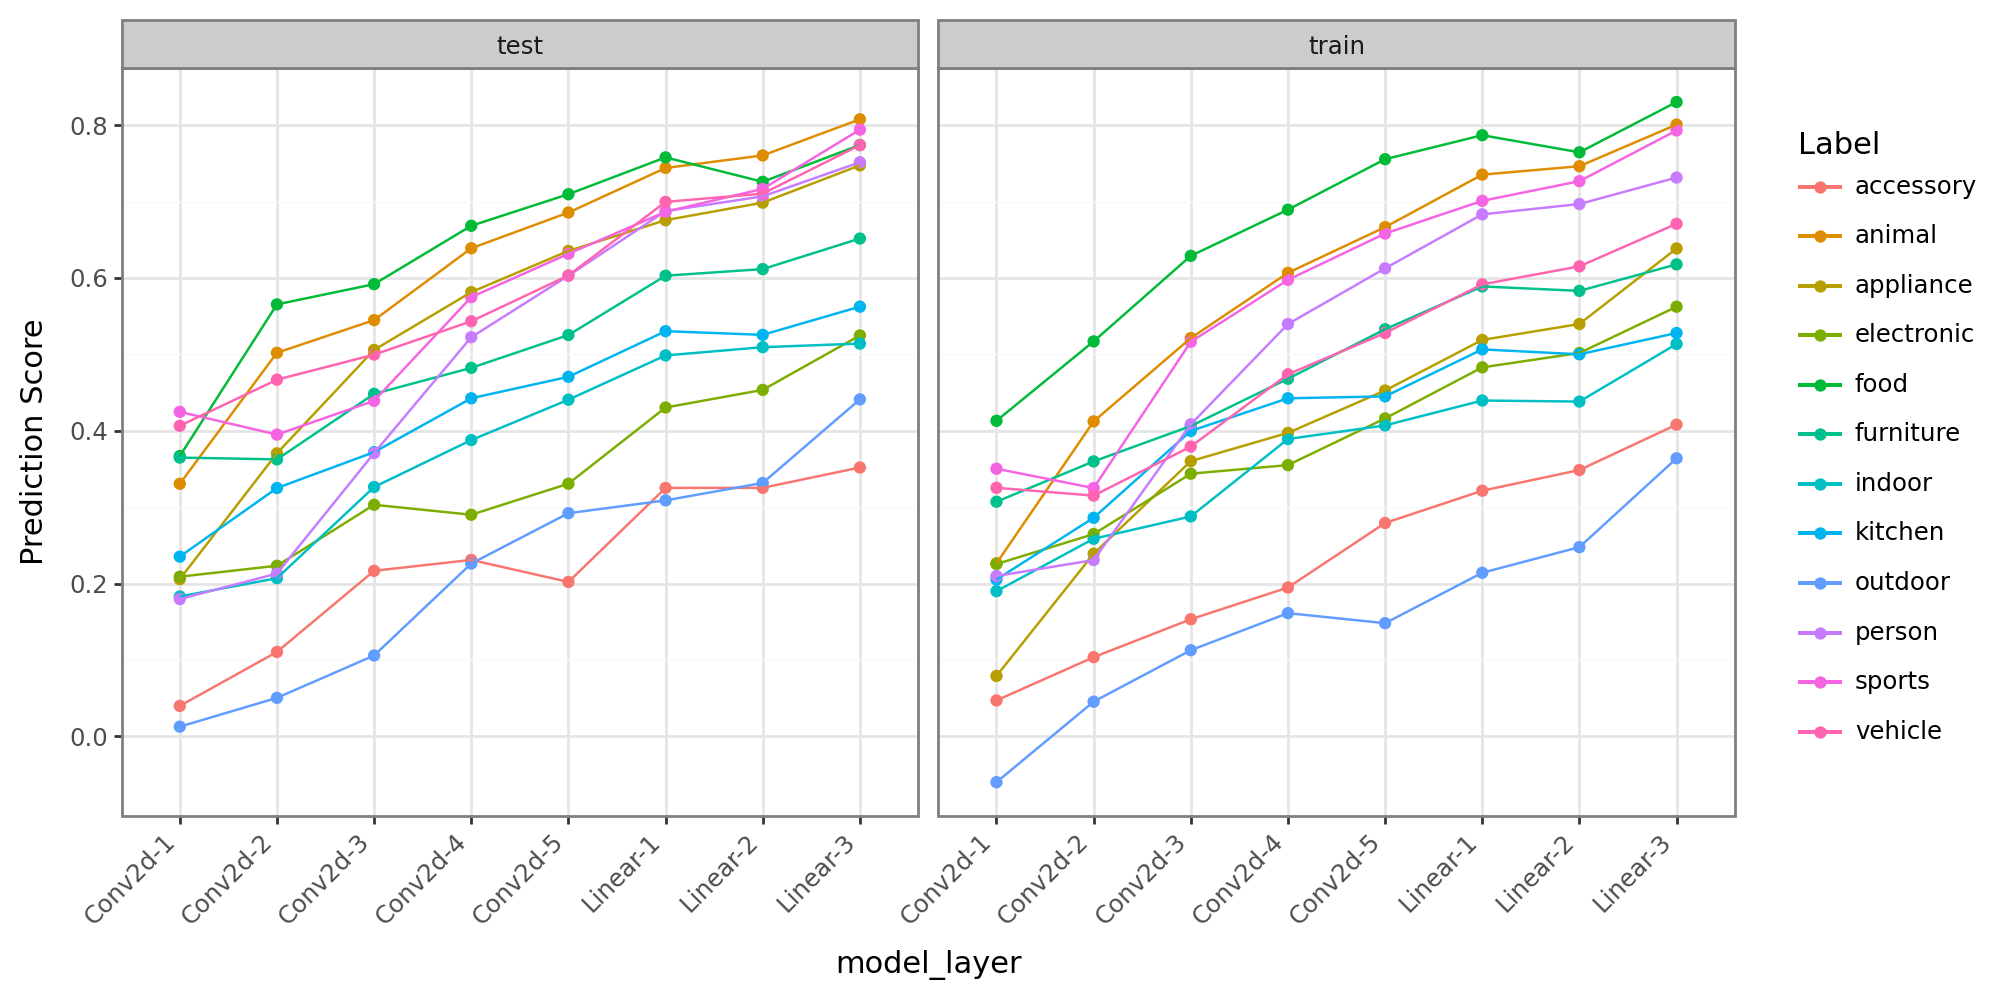

In [26]:
df = results['person_prediction'].copy()
# Convert score (list of 12) into columns
score_df = df['score'].apply(pd.Series)
score_df.columns = labels

# Combine with original metadata
df_long = pd.concat([df[['model_layer', 'score_set']], score_df], axis=1)

# Melt into long format: one row per label
df_long = df_long.melt(id_vars=['model_layer', 'score_set'], 
                       value_vars=labels, 
                       var_name='label', value_name='score_value')
(
    ggplot(df_long, aes('model_layer', 'score_value', color='label', group='label')) +
    geom_point() +
    geom_line() +
    facet_wrap('~score_set', scales='fixed') +
    labs(y='Prediction Score') +
    theme_bw() +
    theme(axis_text_x=element_text(rotation=45, ha='right')) +
    guides(color=guide_legend(title='Label'))
)



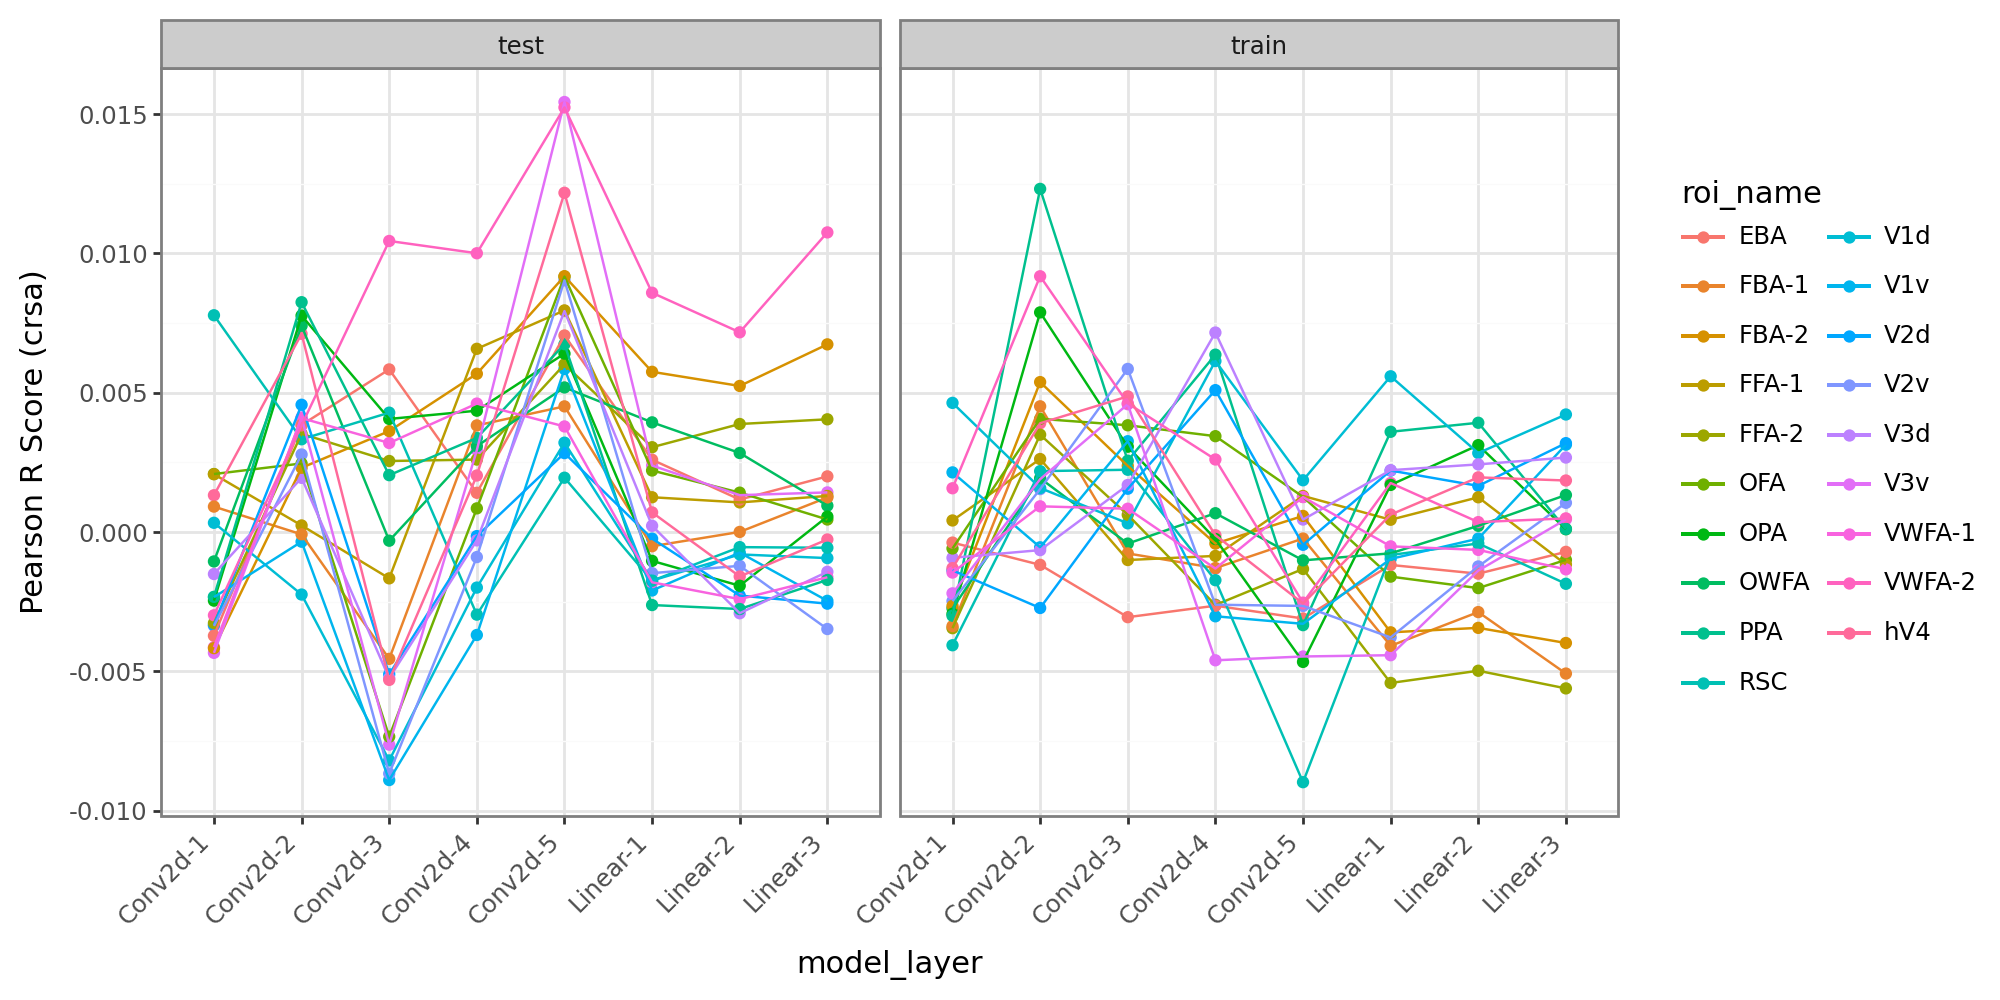

In [25]:
(ggplot(results['crsa'], aes('model_layer', 'score', color = 'roi_name', group = 'roi_name')) +
 geom_point() + geom_line() + facet_wrap('~score_set') + labs(y='Pearson R Score (crsa)') + theme_bw()+theme(axis_text_x=element_text(rotation=45, ha='right')))

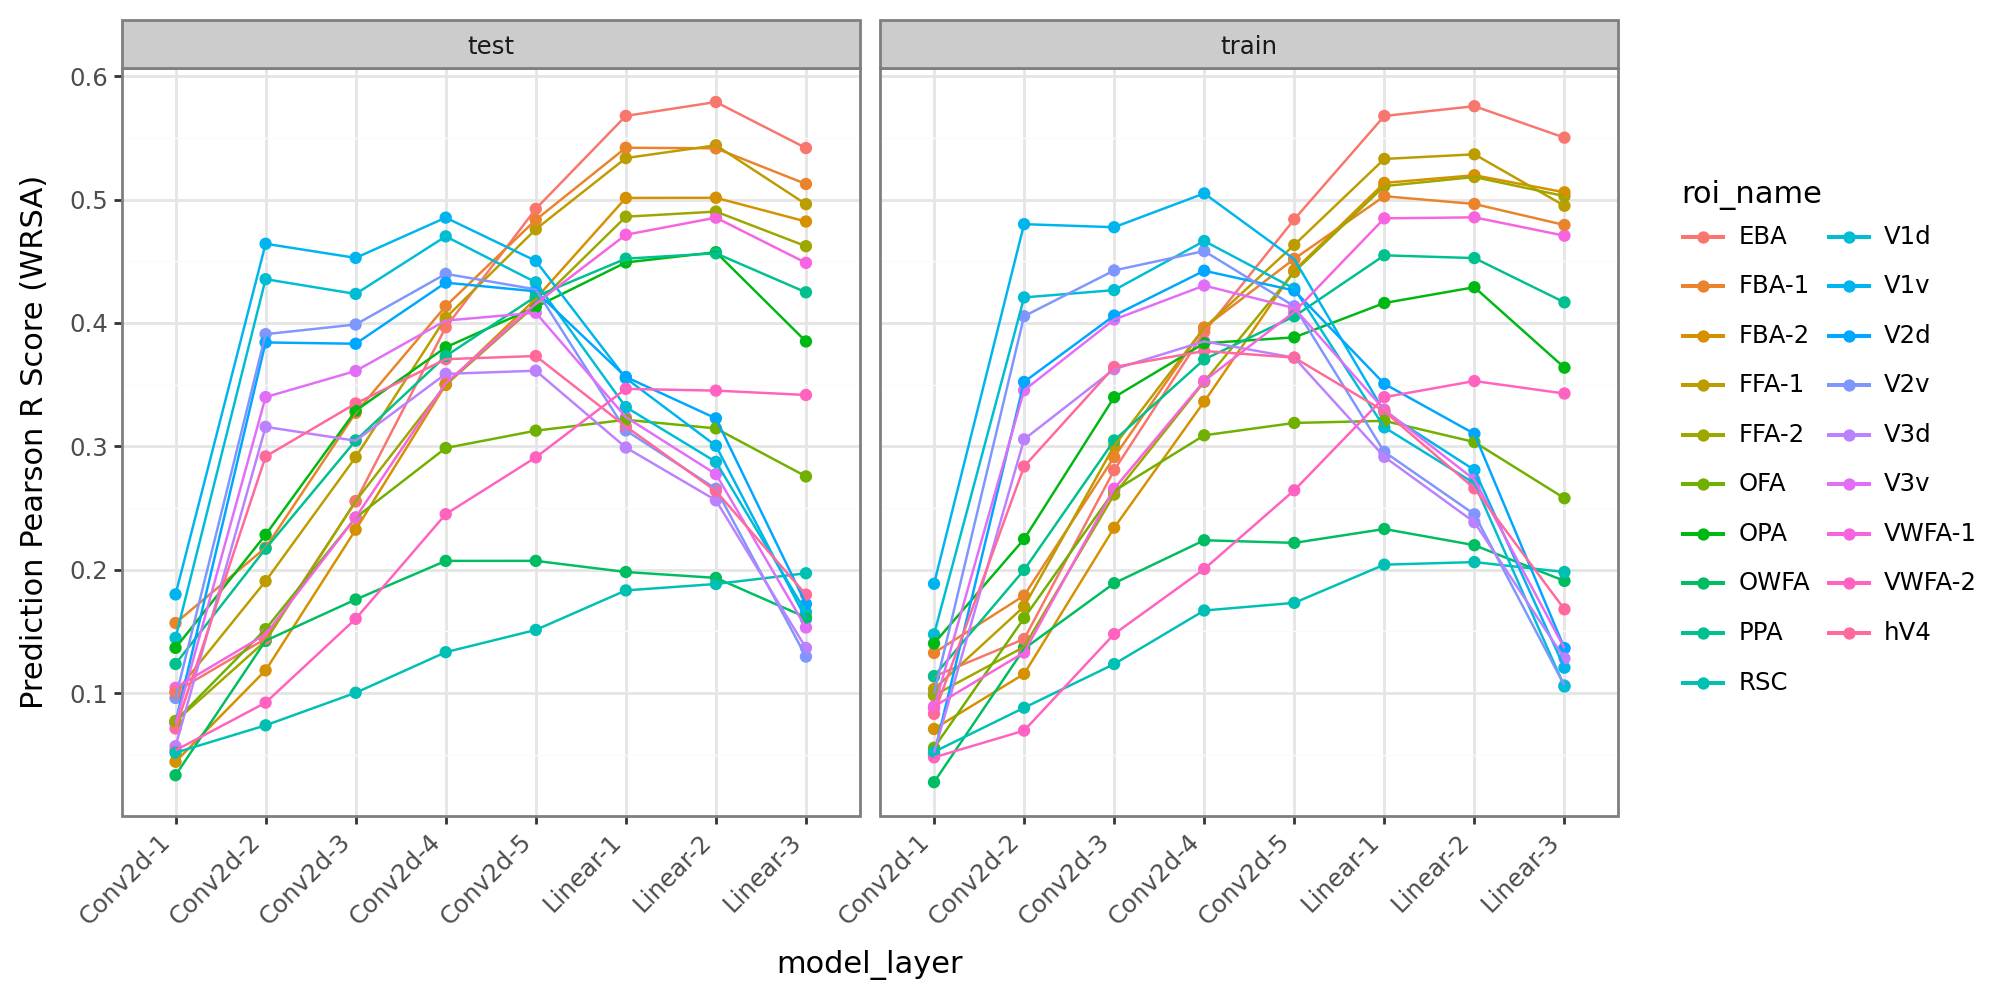

In [24]:
(ggplot(results['wrsa'], aes('model_layer', 'score', color = 'roi_name', group = 'roi_name')) +
 geom_point() + geom_line() + facet_wrap('~score_set') + labs(y='Prediction Pearson R Score (WRSA)') + theme_bw()+theme(axis_text_x=element_text(rotation=45, ha='right')))

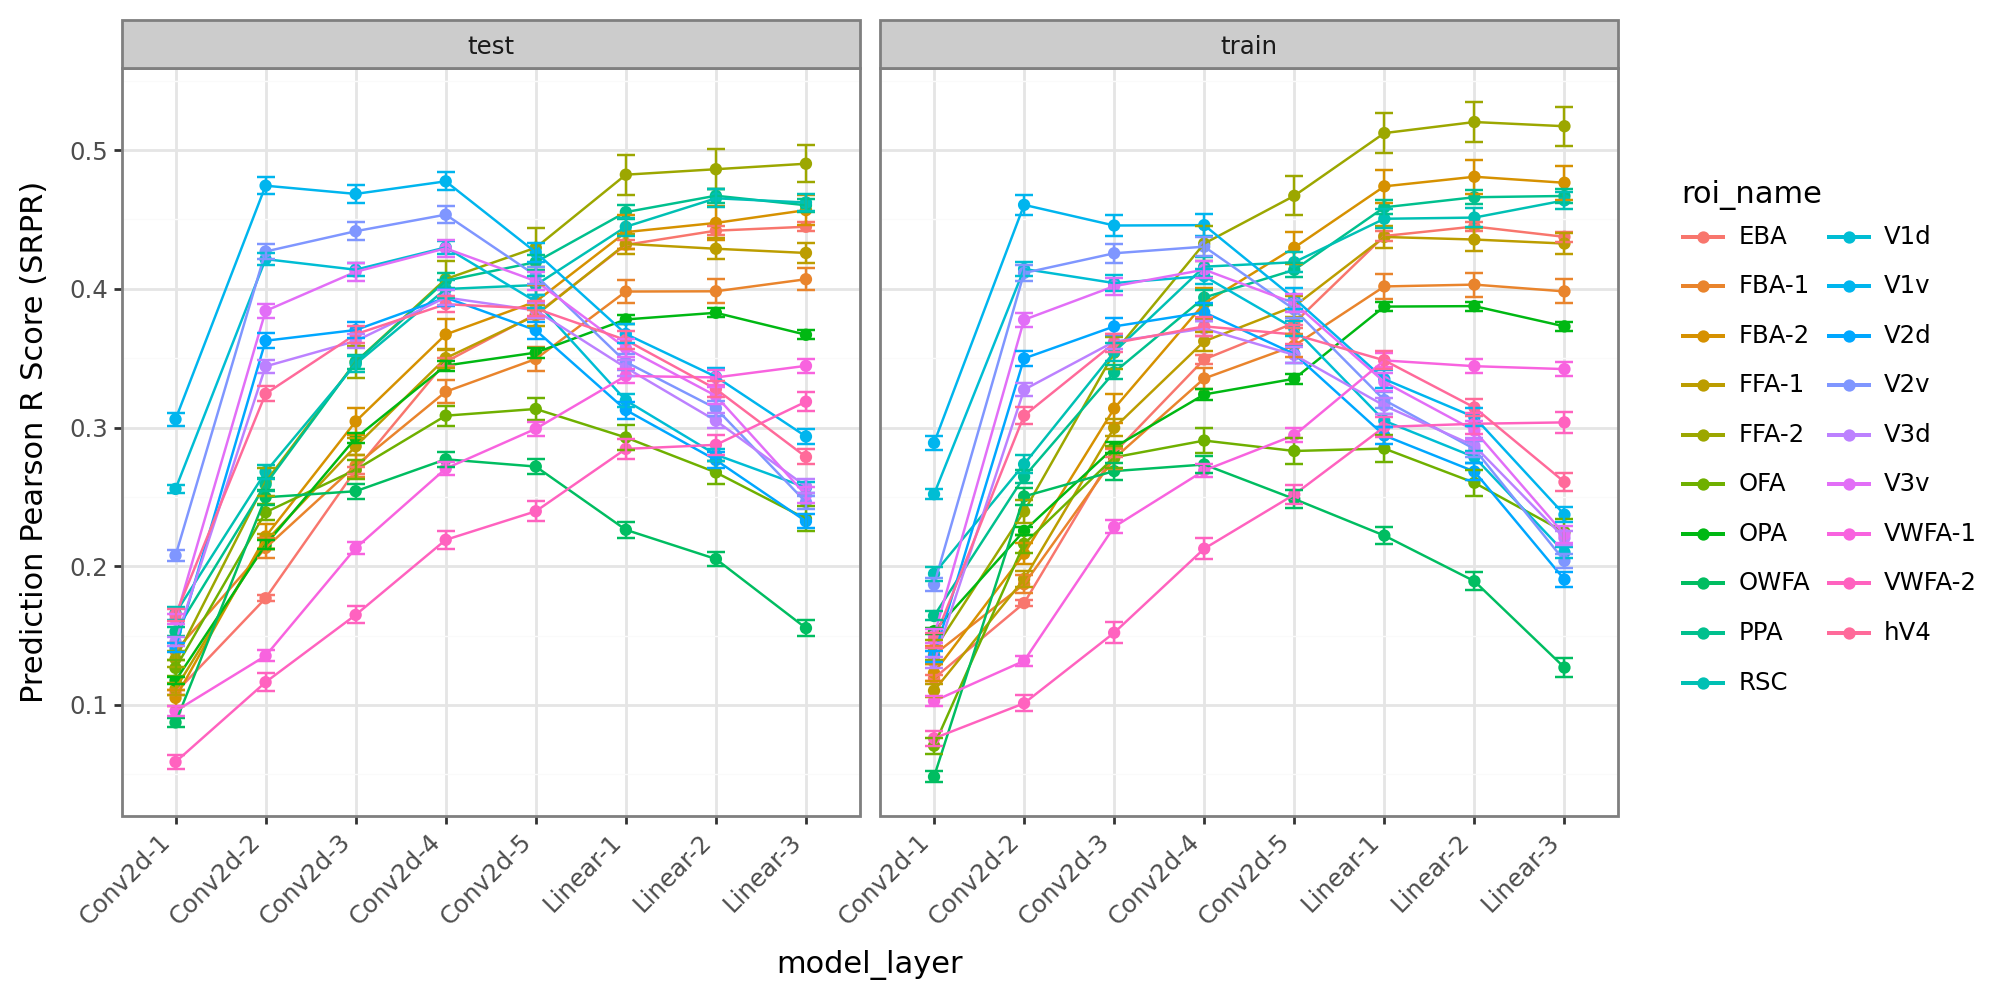

In [23]:
from scipy.stats import sem

# Compute mean and standard error of the mean (STE)
df_grouped = (results['srpr']
              .groupby(['roi_name', 'model_layer', 'score_set'])
              .agg(score_mean=('score', 'mean'),
                   score_ste=('score', sem))  # sem = standard error of mean
              .reset_index())
ggplot(df_grouped, aes('model_layer', 'score_mean', color='roi_name', group='roi_name')) + \
    geom_point() + \
    geom_line() + \
    geom_errorbar(aes(ymin='score_mean - score_ste', ymax='score_mean + score_ste'), width=0.2) + \
    facet_wrap('~score_set') + \
    theme_bw() + \
    theme(axis_text_x=element_text(rotation=45, ha='right')) + \
    labs(y='Prediction Pearson R Score (SRPR)')